<a href="https://colab.research.google.com/github/tri008/graffiti-demo/blob/main/Pothole_Detection_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os

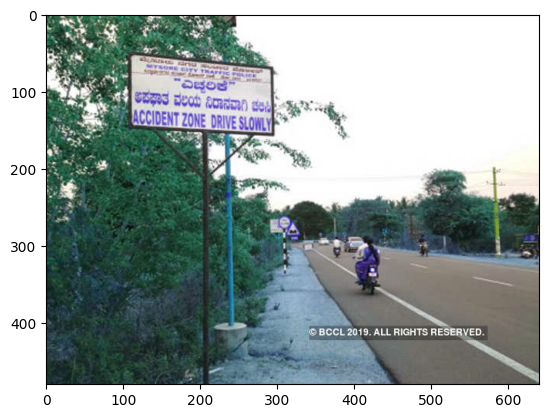

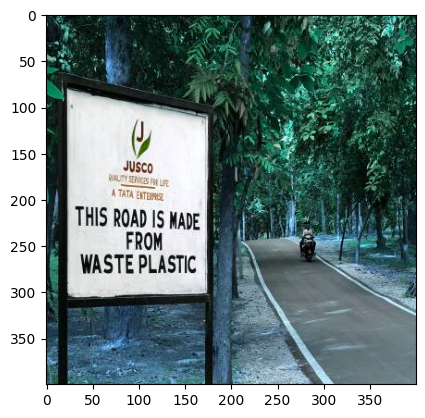

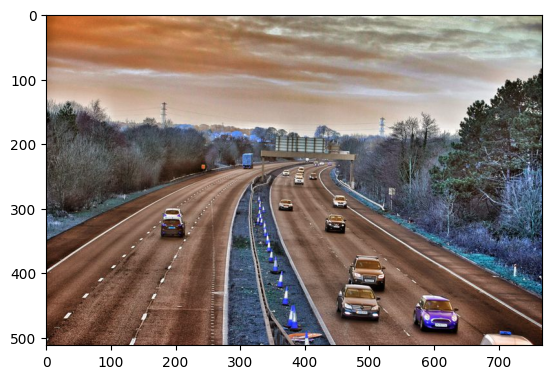

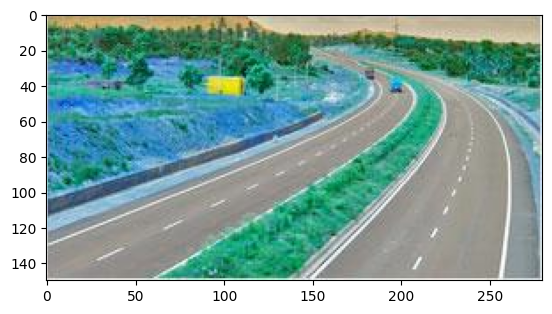

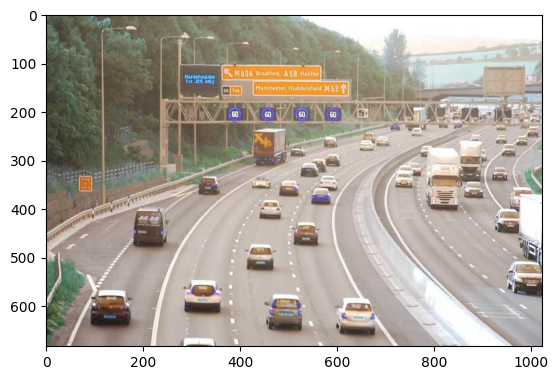

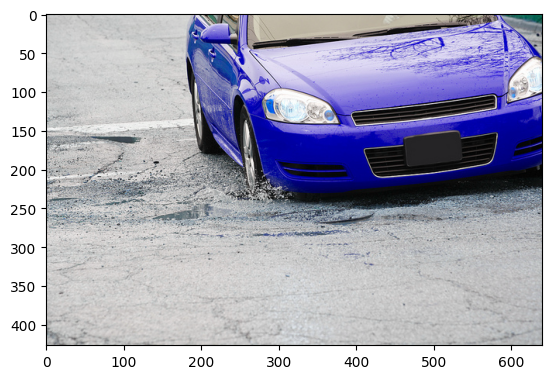

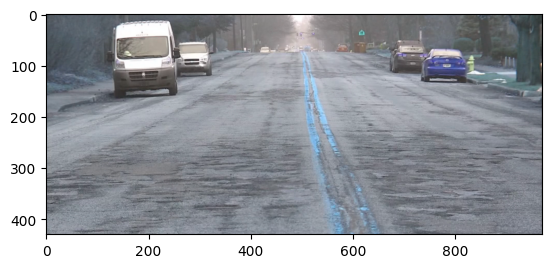

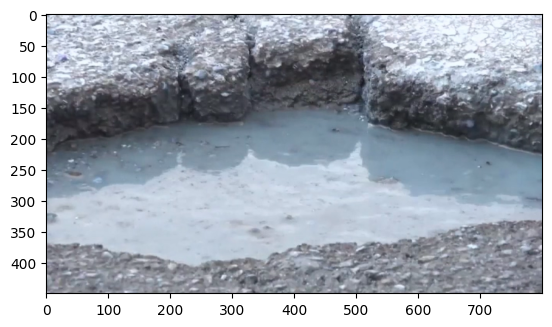

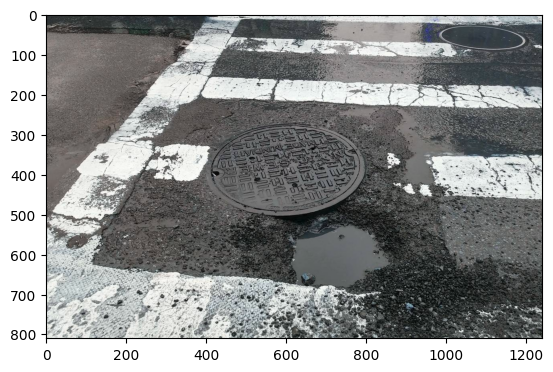

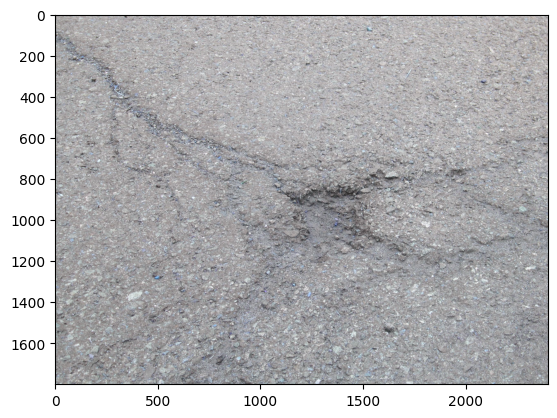

In [2]:
import cv2
import matplotlib.pyplot as plt

def explore_dir(dir_path, count):
    for _, _, filenames in os.walk(dir_path):
        for i in range(count):
            img = cv2.imread(os.path.join(dir_path, filenames[i]))
            plt.imshow(img)
            plt.show()

normal_dir = '/content/drive/MyDrive/archive/normal'
potholes_dir = '/content/drive/MyDrive/archive/potholes'

explore_dir(normal_dir, 5)
explore_dir(potholes_dir, 5)

All the images are grouped into a single dataset X.Normal images will be assigned the label Y = 0; whereas images with potholes will be assigned Y = 1.

In [3]:
desired_size = (150, 150)
X, Y = [], []

def add_images(dir_path, label):
    for _, _, filenames in os.walk(dir_path):
        for file in filenames:
            try:
                img = cv2.imread(os.path.join(dir_path, file))
                img = cv2.resize(img, desired_size)
                X.append(np.array(img))
                Y.append(label)
            except:
                print('Image could not be resized')

add_images(normal_dir, 0)
add_images(potholes_dir, 1)

Image could not be resized


In [4]:
import tensorflow as tf

img_count = len(X)
for i in range(img_count):
    flipped = tf.image.flip_left_right(X[i])
    X.append(flipped)
    Y.append(Y[i])

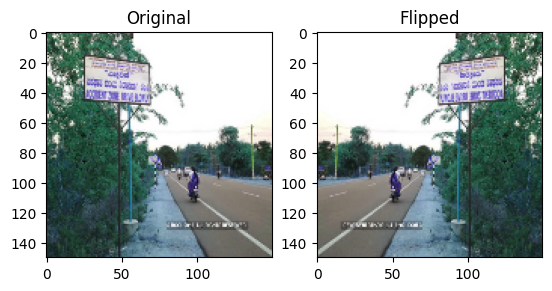

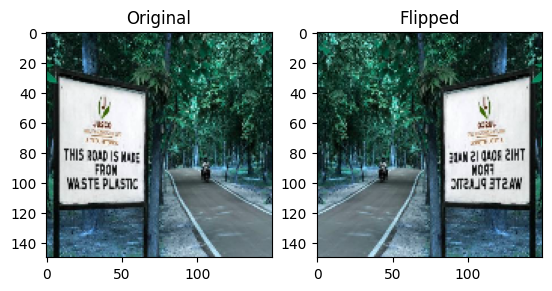

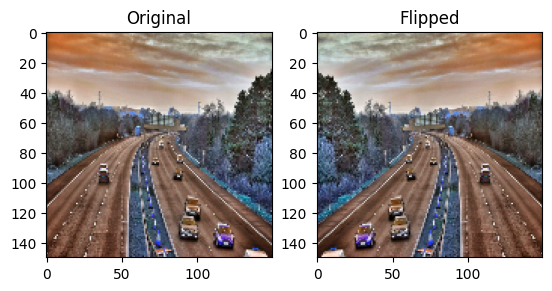

In [5]:
to_visualize = 3

for i in range(to_visualize):
    plt.subplot(1, 2, 1).imshow(X[i])
    plt.title('Original')
    plt.subplot(1, 2, 2).imshow(X[img_count + i])
    plt.title('Flipped')
    plt.show()

Y labels are encoded to be categorical variables


In [6]:
from keras.utils import to_categorical

Y = to_categorical(Y,2)
print(Y)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [7]:
from sklearn.model_selection import train_test_split

X = np.array(X)
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.20, random_state=5)

print(x_train.shape)
print(x_test.shape)

(1088, 150, 150, 3)
(272, 150, 150, 3)


Creation of CNN Model


In [10]:
from tensorflow.keras import datasets, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Flatten,Dropout

cnn = models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.15),
    Dense(2, activation='softmax')
])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 17, 17, 128)       0

In [13]:
from keras.callbacks import  EarlyStopping
from tensorflow.keras.optimizers import Adam

es = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

cnn.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history = cnn.fit(x_train, y_train, epochs=20, batch_size=32,
                    validation_data=(x_test, y_test), callbacks=[es])

Epoch 1/20
34/34 [==============================] - 9s 41ms/step - loss: 10.1158 - accuracy: 0.5855 - val_loss: 0.4704 - val_accuracy: 0.7574
Epoch 2/20
34/34 [==============================] - 1s 25ms/step - loss: 0.3962 - accuracy: 0.8318 - val_loss: 0.2668 - val_accuracy: 0.8860
Epoch 3/20
34/34 [==============================] - 1s 25ms/step - loss: 0.2327 - accuracy: 0.9081 - val_loss: 0.2196 - val_accuracy: 0.9154
Epoch 4/20
34/34 [==============================] - 1s 25ms/step - loss: 0.1443 - accuracy: 0.9467 - val_loss: 0.2405 - val_accuracy: 0.9044
Epoch 5/20
34/34 [==============================] - 1s 27ms/step - loss: 0.0996 - accuracy: 0.9632 - val_loss: 0.1868 - val_accuracy: 0.9265
Epoch 6/20
34/34 [==============================] - 1s 27ms/step - loss: 0.0725 - accuracy: 0.9761 - val_loss: 0.2261 - val_accuracy: 0.9191
Epoch 7/20
34/34 [==============================] - 1s 24ms/step - loss: 0.0543 - accuracy: 0.9825 - val_loss: 0.2191 - val_accuracy: 0.9081
Epoch 8/20
3

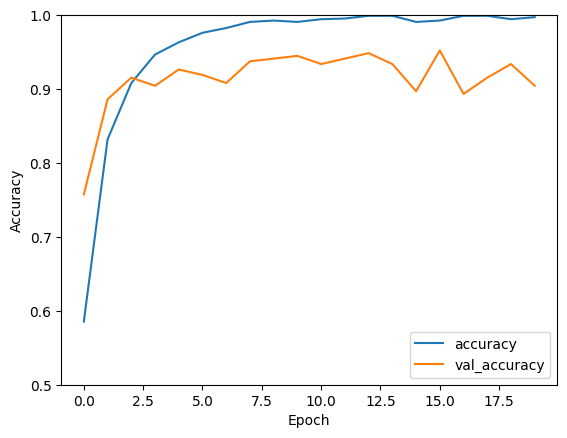

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [15]:
cnn_test_loss, cnn_test_acc = cnn.evaluate(x_test,  y_test, verbose=2)
print('Best accuracy: ', cnn_test_acc)

9/9 - 0s - loss: 0.1640 - accuracy: 0.9522 - 111ms/epoch - 12ms/step
Best accuracy:  0.9522058963775635
